# 데이터 로드

In [1]:
!pip install roboflow
!pip install keras_cv

from roboflow import Roboflow
rf = Roboflow(api_key="CWROiBllXAfAbcRUp2iV")
project = rf.workspace("joseph-nelson").project("hard-hat-workers")
dataset = project.version(14).download("tensorflow")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstall

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Hard-Hat-Workers-14 in tensorflow:: 100%|██████████| 7043/7043 [00:01<00:00, 4090.77it/s]


# 사용할 모듈 정의

In [12]:
import numpy as np
import pandas as pd
import os
import sys
from tqdm.auto import tqdm

import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

# CONFIG

In [13]:
CONFIG = {
    "batch_size" : 8,
    "image_size" : (420, 420),
    "initial_lr" : 0.001,
    "epochs" : 10,
}

# 데이터 확인해보기

In [3]:
HOME = os.getcwd()
print(HOME)

/content


In [4]:
train_file_path = HOME + "/Hard-Hat-Workers-14/train"
train_file_list = os.listdir(train_file_path)
for file_name in train_file_list:
  if not file_name.endswith(".jpg"):
    print(file_name)
    break

_annotations.csv


In [14]:
y_train = pd.read_csv("/content/Hard-Hat-Workers-14/train/_annotations.csv")
y_train.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,003015_jpg.rf.8fa60d2041e2cabec3be0c70cda3dab8...,500,333,head,136,76,202,154
1,001066_jpg.rf.904be8f002aab24c632b8c2e9b2cb18b...,300,300,head,171,148,181,161


In [6]:
xyxy_cols = ["xmin", "ymin", "xmax", "ymax"]

def get_center_df(df):
  min_cols = ["xmin", "ymin"]
  max_cols = ["xmax", "ymax"]
  x_list = ((df["xmax"] + df["xmin"]) / 2).to_numpy()
  y_list = ((df["ymax"] + df["ymin"]) / 2).to_numpy()
  return pd.DataFrame({"x_center" : x_list, "y_center" : y_list})

center_df = get_center_df(y_train)
df_with_center = y_train.copy()
df_with_center["x_center"] = center_df["x_center"]
df_with_center["y_center"] = center_df["y_center"]
df_with_center.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,x_center,y_center
0,003015_jpg.rf.8fa60d2041e2cabec3be0c70cda3dab8...,500,333,head,136,76,202,154,169.0,115.0
1,001066_jpg.rf.904be8f002aab24c632b8c2e9b2cb18b...,300,300,head,171,148,181,161,176.0,154.5


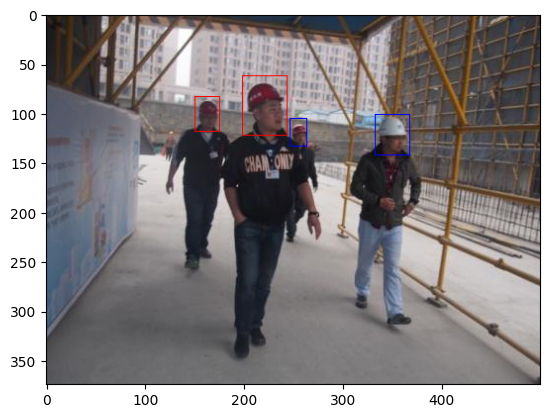

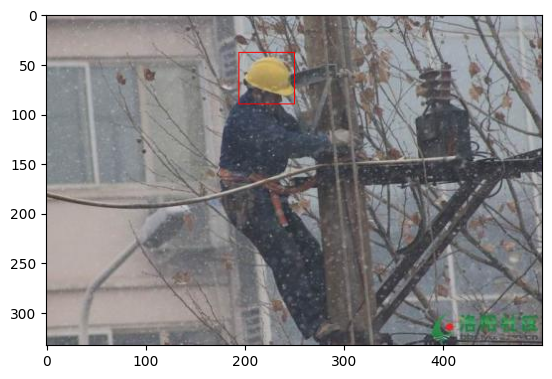

In [7]:
from tensorflow.image import draw_bounding_boxes
from tensorflow.keras.utils import load_img
from tensorflow import convert_to_tensor
import random

def get_bounding_boxes(file_name, image_shape):
  yxyx_cols = ["ymin", "xmin", "ymax", "xmax"]
  height, width = tf.cast(image_shape[:2], "float32").numpy()
  boxes = y_train[y_train["filename"] == file_name][yxyx_cols]
  boxes /= [height, width, height, width]
  boxes = np.expand_dims(boxes, axis=0)
  return tf.cast(tf.convert_to_tensor(boxes), "float32")


def show_random_image(cnt):
  colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
  for i in range(cnt):
    idx = random.randint(0, len(y_train)-1)
    image_path = train_file_path + "/" + y_train.iloc[idx].filename
    image_tensor = convert_to_tensor(load_img(image_path), dtype="float32") / 255.0
    image_shape = image_tensor.shape
    image_tensor = tf.expand_dims(image_tensor, axis=0)
    bounding_boxes = get_bounding_boxes(y_train.iloc[idx].filename, image_shape)
    image_with_box = draw_bounding_boxes(image_tensor, bounding_boxes, colors)
    plt.imshow(image_with_box.numpy()[0], cmap='gray')
    plt.show()


show_random_image(2)

In [8]:
y_train["class"].unique()

array(['head'], dtype=object)

In [17]:
def load_df(path):
  df = pd.read_csv(path)
  df["filename"] = df["filename"].apply(lambda x : path + '/' + x)
  return df

train_df = load_df("/content/Hard-Hat-Workers-14/train/_annotations.csv")
valid_df = load_df("/content/Hard-Hat-Workers-14/valid/_annotations.csv")
test_df = load_df("/content/Hard-Hat-Workers-14/test/_annotations.csv")
print(train_df.shape, valid_df.shape, test_df.shape)

(18531, 8) (5252, 8) (2641, 8)


# 데이터 파이프라인

4916

In [ ]:
# !git clone https://github.com/Visual-Behavior/detr-tensorflow.git
# sys.path.append("detr-tensorflow")

# from detr_tf.data import load_tfcsv_dataset
# from detr_tf.training_config import TrainingConfig, DataConfig

# class MyConfig(TrainingConfig):
#     def __init__(self):
#         super().__init__()
#         self.data_dir = "/content/Hard-Hat-Workers-14/"
#         self.data = DataConfig(data_dir=self.data_dir, img_dir="train", ann_file="train/_annotations.csv")
#         self.batch_size = 8
#         self.image_size = (420, 420)

# class ValidConfig(TrainingConfig):
#     def __init__(self):
#         super().__init__()
#         self.data_dir = "/content/Hard-Hat-Workers-14/"
#         self.data = DataConfig(data_dir=self.data_dir, img_dir="valid", ann_file="valid/_annotations.csv")
#         self.batch_size = 8
#         self.image_size = (420, 420)

# config = MyConfig()
# v_config = ValidConfig()

# # Load the dataset and exclude the person class (for some reason not all person are labeled on the training set)
# train_iterator, class_names = load_tfcsv_dataset(config, config.batch_size, augmentation=True)
# valid_iterator, class_names = load_tfcsv_dataset(v_config, v_config.batch_size, augmentation=False)
# print("class_names", class_names)

# from detr_tf.inference import numpy_bbox_to_image
# import numpy as np
# import matplotlib.pyplot as plt

# for images, target_bbox, target_class in train_iterator:
#     print("images.shape", images.shape)
#     print("target_bbox.shape", target_bbox.shape)
#     print("target_class.shape", target_class.shape)

#     # Plot image
#     image = numpy_bbox_to_image(
#         np.array(images[0]),
#         np.array(target_bbox[0]),
#         labels=np.array(target_class[0]),
#         scores=None,
#         class_name=class_names,
#         config=config
#     )
#     plt.imshow(image)
#     break

class_names ['background', 'head']
